In [ ]:
import os
import wrds
from dotenv import load_dotenv

load_dotenv()

db = wrds.Connection(
    wrds_username=os.getenv("WRDS_USERNAME")
)

print("WRDS connection successful")

Loading library list...
Done
WRDS connection successful


# Relationship between Dividend Yield and Profitability

## Overview
This project examines the relationship between **corporate dividend policy** and **firm profitability** using U.S. equity data from **WRDS (CRSP & Compustat)**.  
Specifically, it investigates whether firms that distribute dividends exhibit systematically different profitability characteristics compared to non-dividend-paying firms.

The analysis is conducted at the **firm-year panel level**, enabling consistent cross-sectional and temporal comparisons across publicly traded U.S. companies.

---

## Data Sources
The dataset is constructed by integrating multiple WRDS tables:

- **CRSP**
  - `crsp.dse`: Dividend events and dividend amounts
  - `crsp.msf`: Monthly stock prices (used to compute year-end prices)
  - `crsp.msenames`: Company names and tickers
- **Compustat**
  - `comp.fundq`: Quarterly financial statements
- **CRSP–Compustat Link Table**
  - `crsp.ccmxpf_linktable`: Firm identifier linkage between CRSP and Compustat

## Data Construction Pipeline
The dataset is built through the following steps:

1. **Annual Dividend Aggregation**
   - Dividend payments are aggregated at the firm-year level using declaration dates.
   - Firms with no dividend payments in a given year are explicitly retained with zero dividends.

2. **Year-End Stock Price Extraction**
   - For each firm-year, the last available monthly stock price is selected to represent the year-end price.
   - Dividend yield is computed using this year-end price to maintain consistency with standard financial definitions.

3. **Firm Identifier Harmonization**
   - CRSP `permno` and Compustat `gvkey` are linked using the official CRSP–Compustat mapping table.
   - To avoid duplicate observations, a **single representative link per firm-year** is selected based on link validity periods.

4. **Profitability Measurement**
   - Annual net income is constructed by summing quarterly net income (`niq`).
   - Average total assets are computed from quarterly asset values.
   - **Return on Assets (ROA)** is calculated as:
     \[
     ROA = \frac{\text{Annual Net Income}}{\text{Average Total Assets}}
     \]

---

## Final Dataset Structure
Each row in the final dataset represents a **unique firm-year observation** with the following variables:

| Variable | Description |
|--------|------------|
| `permno` | CRSP permanent security identifier |
| `company` | Firm name |
| `ticker` | Stock ticker |
| `year` | Fiscal year |
| `annual_dividend` | Total dividends paid during the year |
| `year_end_prc` | Year-end stock price |
| `year_end_date` | Date of the year-end price |
| `dividend_yield_year_end` | Dividend yield based on year-end price |
| `annual_net_income` | Annual net income |
| `avg_total_assets` | Average total assets |
| `roa` | Return on Assets (profitability metric) |

This structure supports both **cross-sectional** and **panel-based** analyses.

---

## Analytical Focus
The primary research question addressed using this dataset is:

> **Do dividend-paying firms exhibit different profitability characteristics compared to non-dividend-paying firms?**

To answer this question, firms are classified based on dividend payment behavior, and their profitability distributions are compared using:
- Summary statistics
- Distributional analysis
- Time-series aggregation
- Group-level comparisons

This approach emphasizes **interpretability and economic intuition**, rather than purely predictive modeling.

---

## Design Philosophy
- **End-to-end reproducibility**: All feature engineering is performed in SQL.
- **Clean firm-year granularity**: Explicit handling of identifier mappings and duplicate observations.
- **Analysis-ready output**: The final table is immediately usable in pandas for exploratory analysis, visualization, or statistical testing.

---

## Potential Extensions
This dataset can be naturally extended to support:
- Dividend policy persistence analysis
- Lagged profitability → dividend response modeling
- Integration with stock return data for performance evaluation
- Firm size or industry-controlled regressions

---

## Summary
This project demonstrates a robust data engineering and analytical workflow for studying dividend policy using large-scale financial datasets.  
By combining careful identifier management, economically meaningful variable construction, and panel-based analysis, it provides a solid foundation for empirical corporate finance research.


In [ ]:
# Relationship between Dividend Yield and Profitability

dataframe = db.raw_sql("""

                    -- permno, year, totla_div
                    WITH div_y AS(
                    SELECT
                        d.permno,
                        EXTRACT (YEAR FROM d.dclrdt) AS year,
                        SUM(d.divamt) AS total_div
                    FROM crsp.dse d
                    GROUP BY d.permno, EXTRACT (YEAR FROM d.dclrdt)
                    ),

                    -- permno, year, year_end_prc, last_date
                    year_end_prc AS (
                    SELECT DISTINCT ON (m.permno, EXTRACT (YEAR FROM m.date))
                        m.permno,
                        EXTRACT (YEAR FROM m.date) AS year,
                        ABS(m.prc) AS year_end_prc,
                        m.date AS last_date
                    FROM crsp.msf m
                    WHERE m.prc IS NOT NULL
                    ORDER BY m.permno, EXTRACT (YEAR FROM m.date), m.date DESC
                    ),


                    -- permno, comnam, ticker
                    current_names AS (
                    SELECT
                        n.permno,
                        n.comnam,
                        n.ticker
                    FROM (
                        SELECT
                            permno,
                            comnam,
                            ticker,
                            nameendt,
                            ROW_NUMBER() OVER (PARTITION BY permno ORDER BY nameendt DESC, namedt DESC) AS rn
                        FROM crsp.msenames
                        WHERE shrcd IN (10, 11)
                            AND exchcd IN (1, 2, 3)
                    ) n
                    WHERE n.rn = 1
                    ),

                    -- gvkey, lpermno, linkdt, linkenddt
                    link_filtered AS (
                    SELECT 
                        l.gvkey,
                        l.lpermno,
                        l.linkdt,
                        l.linkenddt
                    FROM crsp.ccmxpf_linktable l
                    WHERE l.linktype IN ('LU','LC')
                        AND l.linkprim IN ('P','C')
                    ),

                    -- gvkey, year, total_niq, total_asset
                    fund AS(
                    SELECT 
                        f.gvkey,
                        EXTRACT(YEAR FROM f.datadate) AS year,
                        SUM(f.niq) AS total_niq,
                        AVG(f.atq) AS total_asset
                    FROM comp.fundq f
                    GROUP BY f.gvkey, EXTRACT(YEAR FROM f.datadate)
                    ),

                    -- gvkey, year, total_niq, total_asset, lpermno
                fund_link AS(
                    SELECT
                        gvkey,
                        year,
                        total_niq,
                        total_asset,
                        lpermno
                    FROM (
                        SELECT 
                            fu.gvkey,
                            fu.year,
                            fu.total_niq,
                            fu.total_asset,
                            l.lpermno,
                            ROW_NUMBER() OVER (                         --수정!!--
                                PARTITION BY fu.gvkey, fu.year          --수정!!-- gvkey-year당 하나만 남기기
                                ORDER BY
                                    COALESCE(l.linkenddt, DATE '9999-12-31') DESC,  --수정!!-- 가장 "최근까지 유효"한 링크 우선
                                    COALESCE(l.linkdt,    DATE '0001-01-01') DESC,  --수정!!-- 그 다음 linkdt가 최근인 것
                                    l.lpermno ASC                                  --수정!!-- 마지막 타이브레이커
                            ) AS rn                                      --수정!!--
                        FROM fund fu
                        JOIN link_filtered l
                        ON fu.gvkey = l.gvkey
                        WHERE (l.linkdt IS NULL OR l.linkdt <= make_date(fu.year::int, 12, 31))
                        AND (l.linkenddt IS NULL OR l.linkenddt >= make_date(fu.year::int, 1, 1))
                    ) z
                    WHERE rn = 1                                         --수정!!-- 중복 제거 핵심
                )

                    
                    -- permno, company, ticker, year, annual_dividend, year_end_prc, year_end_date, dividend_yield_year_end, annual_net_income, avg_total_assets, roa
                    SELECT 
                        f.lpermno AS permno,
                        cn.comnam AS company,
                        cn.ticker,
                        f.year,
                        COALESCE(d.total_div, 0) AS annual_dividend,

                        y.year_end_prc,
                        y.last_date AS year_end_date,
                        (COALESCE(d.total_div,0) / NULLIF(y.year_end_prc,0)) * 100 AS dividend_yield_year_end,

                        f.total_niq AS annual_net_income,
                        f.total_asset AS avg_total_assets,
                        (f.total_niq / NULLIF(f.total_asset, 0)) AS roa
                    FROM fund_link f
                    JOIN current_names cn
                        ON cn.permno = f.lpermno
                    
                    LEFT JOIN div_y d
                        ON d.year = f.year
                        AND d.permno = f.lpermno

                    LEFT JOIN year_end_prc y
                        ON y.permno = f.lpermno
                        AND y.year = f.year
                    ORDER BY f.year
                        """)

dataframe

,permno,company,ticker,year,annual_dividend,year_end_prc,year_end_date,dividend_yield_year_end,annual_net_income,avg_total_assets,roa
0,25160.0,GREAT NORTHERN NEKOOSA CORP,GNN,1961.0,0.0,55.5,1961-12-29,0.0,0.568,<NA>,<NA>
1,11607.0,DANA CORP,DCN,1961.0,0.0,44.5,1961-12-29,0.0,3.716,<NA>,<NA>
2,17953.0,BEATRICE CO,BRY,1961.0,0.0,70.0,1961-12-29,0.0,6.94,<NA>,<NA>
3,12749.0,K MART CORP,KM,1961.0,0.0,34.5,1961-12-29,0.0,9.014,<NA>,<NA>
4,10321.0,AMERICAN MOTORS CORP,AMO,1961.0,0.0,16.75,1961-12-29,0.0,9.22,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...
273915,25466.0,GUARDIAN PHARMACY SERVICES INC,GRDN,2025.0,0.0,<NA>,<NA>,<NA>,28.296,360.123,0.078573
273916,88260.0,PIXELWORKS INC,PXLW,2025.0,0.0,<NA>,<NA>,<NA>,-18.9,53.595,-0.352645
273917,22245.0,2SEVENTY BIO INC,TSVT,2025.0,0.0,<NA>,<NA>,<NA>,0.482,480.005,0.001004
273918,14033.0,ORGANOVO HOLDINGS INC,ONVO,2025.0,0.0,<NA>,<NA>,<NA>,1.464,12.104667,0.120945


In [6]:
df = pd.DataFrame(dataframe).copy()
df = df[df["year"] != 2025].copy()

df["is_dividend"] = (df["annual_dividend"] > 0).astype(int)

div = df[df["is_dividend"] == 1]
nondiv = df[df["is_dividend"] == 0]

grp = df.groupby("is_dividend")["roa"].agg(["count","mean","median","std"])
grp.index = ["Non-dividend", "Dividend"]
grp

,count,mean,median,std
Non-dividend,153900,-0.136908,0.000094,1.340988
Dividend,98872,0.051813,0.040417,0.621624


## Profitability Comparison: Dividend vs. Non-Dividend Firms

The table compares profitability (ROA) between dividend-paying and non-dividend-paying firms. Dividend-paying firms exhibit **higher average and median ROA**, while non-dividend-paying firms show **lower and more volatile profitability**, including a negative average ROA.

Overall, the results suggest that dividend payments are more prevalent among firms with **stable and sustained profitability**, whereas non-dividend firms tend to display greater earnings variability.


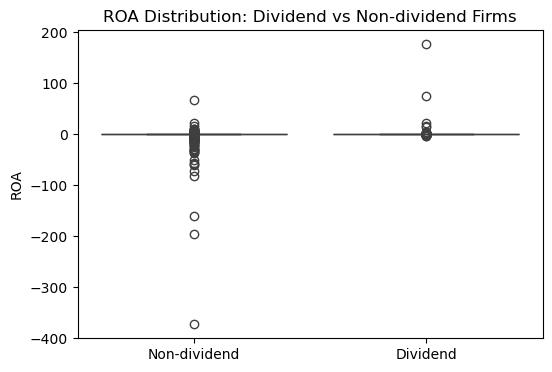

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.boxplot(
    data=df,
    x="is_dividend",
    y="roa"
)
plt.xticks([0,1], ["Non-dividend", "Dividend"])
plt.title("ROA Distribution: Dividend vs Non-dividend Firms")
plt.ylabel("ROA")
plt.xlabel("")
plt.show()


### ROA Distribution by Dividend Status

The boxplot illustrates the distribution of ROA for dividend-paying and non-dividend-paying firms. Dividend-paying firms display a **higher central tendency and tighter distribution**, while non-dividend firms exhibit **substantially greater dispersion**, including extreme negative outliers.

This distributional difference reinforces the earlier summary statistics, suggesting that dividend-paying firms tend to have **more stable profitability**, whereas non-dividend firms are more heterogeneous in financial performance.


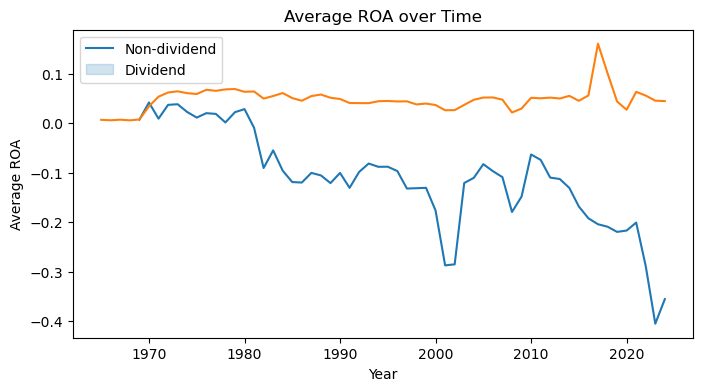

In [8]:
roa_year = (
    df.groupby(["year","is_dividend"])["roa"]
      .mean()
      .reset_index()
)

plt.figure(figsize=(8,4))
sns.lineplot(
    data=roa_year,
    x="year",
    y="roa",
    hue="is_dividend"
)
plt.legend(title="", labels=["Non-dividend","Dividend"])
plt.title("Average ROA over Time")
plt.ylabel("Average ROA")
plt.xlabel("Year")
plt.show()


### Average ROA over Time by Dividend Status

The time-series plot shows that dividend-paying firms consistently maintain **higher average ROA across time**, while non-dividend-paying firms exhibit **greater volatility and prolonged periods of negative profitability**, particularly after the early 1980s.

The persistent gap between the two groups suggests that dividend policy is closely associated with **long-run profitability and earnings stability**, rather than being driven by short-term performance.


C:\Users\Hyunwoo Jang\AppData\Local\Temp\ipykernel_20676\3443033442.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("roa_q")["is_dividend"]


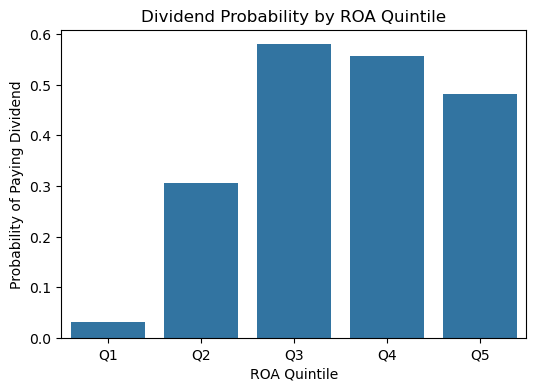

In [9]:
df["roa_q"] = pd.qcut(df["roa"], 5, labels=["Q1","Q2","Q3","Q4","Q5"])

prob = (
    df.groupby("roa_q")["is_dividend"]
      .mean()
      .reset_index()
)

plt.figure(figsize=(6,4))
sns.barplot(
    data=prob,
    x="roa_q",
    y="is_dividend"
)
plt.title("Dividend Probability by ROA Quintile")
plt.ylabel("Probability of Paying Dividend")
plt.xlabel("ROA Quintile")
plt.show()


### Dividend Probability by ROA Quintile

The bar chart shows a strong monotonic relationship between profitability and dividend payments. Firms in higher ROA quintiles are **substantially more likely to pay dividends**, while firms in the lowest profitability quintile rarely distribute dividends.

This pattern suggests that dividend policy is closely tied to firms’ **ability to generate sustainable profits**, rather than being uniformly applied across firms.
